
# Movies Analysis for Microsoft
![microsoft logo](./images/ms_logo.jpg)

## Overview

This project shows analysis on movie markets to help Microsoft start building a new movie studio. Several key aspects of popular movies are selected for the analysis. The analysis includes visualizations that would help on where to start.

## Business Problem

As Microsoft has no background in filming a movie, concrete information is needed for a guide on creating a new movie studio. Microsoft is interested in what is needed to be successful. It would be a good idea to investigate the aspects of the movies that are successful and fairly recent.

## Data Understanding

Data is collected from well-known websites for movie databases. For the analysis, the selected aspects of the movie are [gross & budget](https://www.the-numbers.com/), [genre](https://www.themoviedb.org/), and [runtime](https://www.imdb.com/).

In [1]:
# import necessary libraries
import pandas as pd
import sqlite3

In [2]:
# read data
# profit and budget in csv
df_p = pd.read_csv('data/tn.movie_budgets.csv.gz')

# genre in csv
df_g = pd.read_csv('data/tmdb.movies.csv.gz')

# runtime in sql database
con = sqlite3.connect("data/im.db")

## Three dataset for profit & budget, genre, and runtime
Each source has a different format. One column that can be used for the merge is the name of the movie.

In [3]:
df_p.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [4]:
df_g.head(3)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368


In [5]:
pd.read_sql(""" SELECT * FROM movie_basics; """, con).head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


## Data Preparation

In [6]:
#import libraries to clean data
import code.data_preparation as dp

### Data Cleaning
The movies are chosen with release years on and after 2000, and this range can be modified as well.

In [7]:
# set year and minimum profit
# these can be modified per request
set_year = 2000
set_profit = 10

The budget and gross information are cleaned by removing commas and dollar signs. Then, profit is calculated by subtracting budget from world gross, and then the film with at least $10 million profit is selected. No duplicate row was found. The year value from the release date is extracted.

For genre data, unnecessary columns and duplicate rows are removed.

For runtime data, only necessary columns are selected using SELECT statement. Null values are not selected. No duplicate row was found.

In [8]:
df_p = dp.profit(df_p, set_year, set_profit)
df_g = dp.genre(df_g)
df_r = dp.runtime(con)

Before merging, the movie names were cleaned by three steps.
1. lowercase names
2. remove spaces
3. remove punctuations

In [9]:
df_p.movie = dp.movie_name_clean(df_p.movie)
df_g.title = dp.movie_name_clean(df_g.title)
df_r.primary_title = dp.movie_name_clean(df_r.primary_title)

In [10]:
df_genre = df_p.merge(df_g, how = 'inner', left_on = 'movie', right_on = 'title')
df_runtime = df_p.merge(df_r, how = 'inner', left_on = 'movie', right_on = 'primary_title')

Since each movie can have multiple genres, each element of genre column is cleaned to be a list of genre ids.

In [11]:
Genre = dp.genre_count(df_genre)

## Analysis

In [12]:
import code.visualizations as viz

### Profit distribution
Every movie with at least $10 million profit is selected.

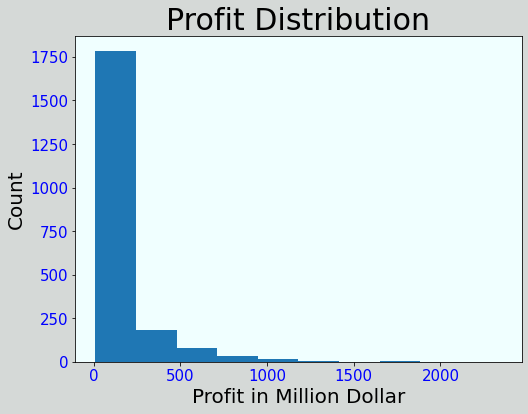

In [13]:
viz.profit(df_p)

### Budget distribution
The majority of movies had a budget below $50 million.

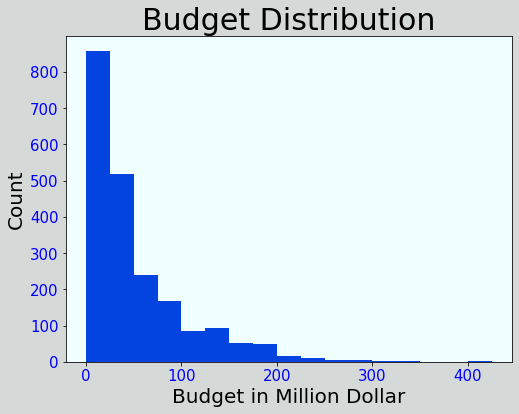

In [14]:
viz.budget(df_p)

### Genre distribution
The most popular genres are drama, comedy, action, thriller, and adventure.

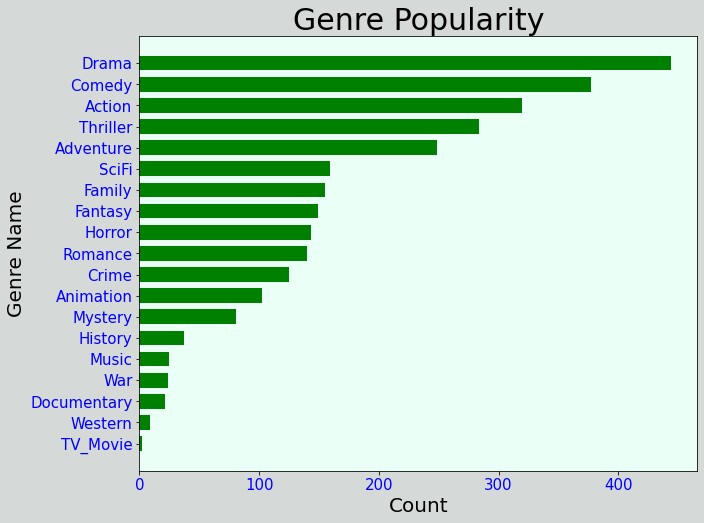

In [15]:
viz.genre(Genre)

###  Runtime distribution
A typical length of movies is between 90 and 120 minutes.

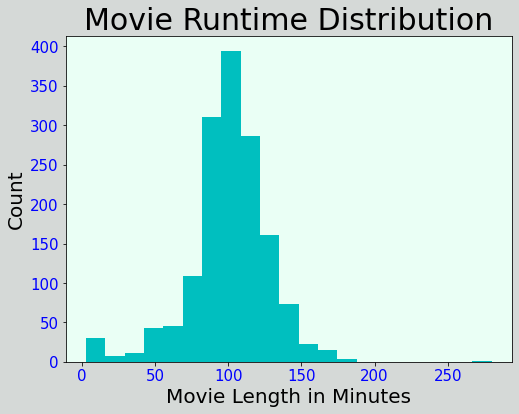

In [16]:
viz.runtime(df_runtime)

## Conclusions

There are three recommendations to consider to build a new movie studio.

- **The estimated budget to film a movie is below 50 million dollars.** There are movies that cost more than 50 million dollars, but the analysis shows Microsoft does not have to spend a similar amount. 
- **The recommended genres for a new movie are drama, comedy, action, thriller, and adventure.** Most movies included multiple genres. If a new movie can include recommended genres as much as possible, this would help lead to a successful business.
- **The runtime for a new movie is recommended to be between 90 to 120 minutes.** The majority of movies are around 100 minutes. Thus, it would be ideal to film a new movie that is close to 100 minutes.

### Next Steps

Further analysis could help gain more ideas on creating a new movie.

- **Run the same analysis again after genres are decided.** Running the same analysis for selected genres would help gain a better insight because selecting genres narrows down to a more specific data sample.
- **More research on the relationship between profit and budget.** The analysis shows a typical budget for all movies with the set amount of profit. A more sophisticated visualization, such as a scatter plot, on a smaller sample, is advised for a more precise result.
- **Find more aspects of movies such as casting size and age rating** Movies can be analyzed in more ways by including more aspects.